In [1]:
import pydicom
import xmltodict
import numpy as np
import cv2
import os

XMLfile = "20586908.xml"
DICOMfile = "20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm"
DICOMfile2 = "20586934_6c613a14b80a8591_MG_L_CC_ANON.dcm"

DICOM_PATH = "J:\Dataset\INbreast Release 1.0\AllDICOMs"
XML_PATH = "J:\Dataset\INbreast Release 1.0\AllXML"
MASK_PATH = "J:\Dataset\INbreast Release 1.0\AllMASK"

In [7]:
# Usage : Parse XML file of ROI
# Params : 
#   file: .xml file name
# Return: A list of calcification ROIs, each ROI may contain a point or a list of points(depends on the xml file)
# Note  : A point is described as a list of 2 elements like [x, y]
def get_rois(file):
    xml_file = open(XML_PATH + "/" + file + ".xml", 'r')
    xml_str = xml_file.read()
    xml_dict = xmltodict.parse(xml_str)
    array = xml_dict['plist']['dict']['array']['dict']['array']['dict']
    rois = []
    if isinstance(array, list):
        for item in array:
            if item['string'][1]=="Calcification":
                calcs = item['array'][1]['string']
                if isinstance(calcs, str):
                    xy = calcs.replace(" ","").replace("(","").replace(")","").split(",")
                    rois.append([int(float(xy[0])),int(float(xy[1]))])
                else:
                    roi = []
                    for calc in calcs:
                        xy = calc.replace(" ","").replace("(","").replace(")","").split(",")
                        roi += [[int(float(xy[0])),int(float(xy[1]))]]
                    rois.append(roi)
    else:
        item = array
        if item['string'][1]=="Calcification":
                calcs = item['array'][1]['string']
                if isinstance(calcs, str):
                    xy = calcs.replace(" ","").replace("(","").replace(")","").split(",")
                    rois.append([int(float(xy[0])),int(float(xy[1]))])
                else:
                    roi = []
                    for calc in calcs:
                        xy = calc.replace(" ","").replace("(","").replace(")","").split(",")
                        roi += [[int(float(xy[0])),int(float(xy[1]))]]
                    rois.append(roi)
    return rois

result1 = get_rois("20587758")
result2 = get_rois("20586908")

(4084, 3328)


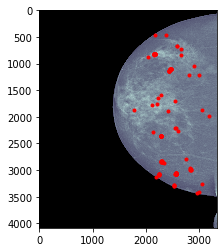

In [3]:
# Usage : Create a new .dcm file with ROIs
# Params :
#   file: .dcm file path
# Return: None
# Note  : A new .dcm file will be created with name "newdicom.dcm"
# def draw_rois(file):
#     ds = pydicom.dcmread(file)
#     plt.imshow(ds.pixel_array, cmap = plt.cm.bone)
#     print(ds.pixel_array.shape)
#     for roi in rois:
#         if(isinstance(roi[0], list)):
#             for point in roi:
#                 plt.scatter(point[0], point[1], c='r', marker='.')
#                 ds.pixel_array[point[1]][point[0]] = 4000
#         else:
#             plt.scatter(roi[0], roi[1], c='r', marker='.')
#             ds.pixel_array[roi[1]][roi[0]] = 4000
#     ds.PixelData = ds.pixel_array.tostring()
#     ds.save_as('./newdicom.dcm')
#     plt.show()

In [3]:
# Usage : Get pixel size of .dcm file
# Params :
#   file: .dcm file name
# Return: A tuple of size (Width, Height)
def get_dcm_shape(file):
    return pydicom.dcmread(DICOM_PATH + "/" + file + ".dcm").pixel_array.shape

In [4]:
# Usage : Generate mask image
# Params : 
#   file: .dcm file name
# Return: Mask image
def generate_mask(file):
    shape = get_dcm_shape(file)
    rois = get_rois(file.split("_")[0])
    mask = np.zeros(shape, dtype = np.uint8)
    for roi in rois:
        if isinstance(roi[0], list):
            cv2.fillPoly(mask, [np.array(roi)], 255)
        else:
            mask[roi[1]][roi[0]] = 255
    cv2.imwrite(MASK_PATH + "/" + file + "_mask.jpg", mask)
    return mask

In [5]:
def convert_roi_to_mask():
    files = os.listdir(DICOM_PATH)
    for file in files:
        print("start generate mask for " + file)
        generate_mask(os.path.splitext(file)[0])

In [18]:
# Usage : Get bbox of breast
# Params :
#   file: .dcm file path
# Return: A list of bbox like [start_row, end_row, start_col, end_col]
def generate_bbox(file):
    dicom = pydicom.dcmread(file)
    pixel_data = dicom.pixel_array
    image = np.array(pixel_data)
    col = np.amax(image, axis=0)
    row = np.amax(image, axis=1)
    col_index = np.nonzero(col)
    row_index = np.nonzero(row)
    return [row_index[0].min(), row_index[0].max(), col_index[0].min(), col_index[0].max()]

In [19]:
# Usage : Get crop region of dataset
# Params: 
#   path: dataset path
# Return: A list of crop region like [start_row, end_row, start_col, end_col]
def get_crop_region(path):
    files = os.listdir(path)
    region = [0, 0]
    for file in files:
        bbox = generate_bbox(path + "/" + file)
        array = np.array([region, [bbox[1]-bbox[0], bbox[3]-bbox[2]]])
        region = np.amax(array, axis=0)
    return region

# 运行结果：[4071, 2725]的框为最小框


array([4071, 2725], dtype=int64)

In [8]:
convert_roi_to_mask()



start generate mask for 20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm
start generate mask for 20586934_6c613a14b80a8591_MG_L_CC_ANON.dcm
start generate mask for 20586960_6c613a14b80a8591_MG_R_ML_ANON.dcm
start generate mask for 20586986_6c613a14b80a8591_MG_L_ML_ANON.dcm
start generate mask for 20587054_b6a4f750c6df4f90_MG_R_CC_ANON.dcm
start generate mask for 20587080_b6a4f750c6df4f90_MG_R_ML_ANON.dcm
start generate mask for 20587148_fd746d25eb40b3dc_MG_R_CC_ANON.dcm
start generate mask for 20587174_fd746d25eb40b3dc_MG_L_CC_ANON.dcm
start generate mask for 20587200_fd746d25eb40b3dc_MG_R_ML_ANON.dcm
start generate mask for 20587226_fd746d25eb40b3dc_MG_L_ML_ANON.dcm
start generate mask for 20587294_e634830794f5c1bd_MG_R_CC_ANON.dcm
start generate mask for 20587320_e634830794f5c1bd_MG_L_CC_ANON.dcm
start generate mask for 20587346_e634830794f5c1bd_MG_R_ML_ANON.dcm
start generate mask for 20587372_e634830794f5c1bd_MG_L_ML_ANON.dcm
start generate mask for 20587466_d571b5880ad2a016_MG_L_CC_ANON

FileNotFoundError: [Errno 2] No such file or directory: 'J:\\Dataset\\INbreast Release 1.0\\AllXML/20588138.xml'